<a href="https://colab.research.google.com/github/christam96/VinBigData-Abnormalities-Detection/blob/master/Exploratory%20Data%20Analysis/center_of_bounding_box_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [x] Plotting the distribution of locations of each labeled rectangle. So, let's say "0 - Aortic enlargement" would have a 2D plot, end every other class would have its plot. The goal of this would be to discover if a class tends to appear at the same spot.
- [ ] Plot the distribution of average brightness of the dataset's images, this would show if images have more or less the same level of brightness (how diverse images are)
- [ ] Table where rows/columns are classes, and each cell contains the number of times 2 classes appear together on image. This would show if some classes tend to appear together or no.

# Part 1

## link kaggle to colab, download train.csv

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!#kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train/032c81fae916e932002387494a7d7c7b.dicom

In [3]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 59.8MB/s]


In [4]:
!unzip train.csv.zip
!rm train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


## load .csv file

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


## install pydicom, download image in order to get  the shape of it

In [7]:
!pip install -q pydicom

In [8]:
import pydicom as dicom

In [9]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train/fe620114981e611e4e92f017dafc254f.dicom
!unzip fe620114981e611e4e92f017dafc254f.dicom.zip
!rm fe620114981e611e4e92f017dafc254f.dicom.zip  #ba68c12f2141bba79d9c29322c2c295a max

 35% 5.00M/14.3M [00:00<00:00, 25.4MB/s]
100% 14.3M/14.3M [00:00<00:00, 56.6MB/s]
Archive:  fe620114981e611e4e92f017dafc254f.dicom.zip
  inflating: fe620114981e611e4e92f017dafc254f.dicom  


In [10]:
ds=dicom.read_file('fe620114981e611e4e92f017dafc254f.dicom')
img = ds.pixel_array
img = ((img / (2**16 - 1)) * 255).astype("uint8")
print(img.shape)
imShape = (3500, 3500)

(3244, 2992)


## define functions for distribution plotting

In [11]:
def getCenterOfRectangle(df, class_id):
  class_i = (df.class_id == class_id)
  class_i = df.loc[class_i] 
  class_i = class_i.loc[:,["x_min","y_min","x_max","y_max"]]
  class_i = pd.concat([(class_i["y_min"] + class_i["y_max"]) / 2, (class_i["x_min"] + class_i["x_max"]) / 2],axis=1).astype("int16")
  class_i.columns = ["y_c","x_c"]
  return class_i

In [12]:
def accumulatePosArr(centArr, imShape, verbose=False):
  # define accumulator array 
  acc_pos_i = np.zeros([3500,3500],dtype=int)
  class_i = np.array(centArr)
  a = tuple(class_i.T[:,:10].tolist())
  # accumulate acc_pos_i: add +1 to the cells stored in class_i
  np.add.at(acc_pos_i,tuple(class_i.T.tolist()),1)
  if verbose:
    print("Sum of all values in acc_pos_i before resizing: {}".format(np.sum(acc_pos_i)))
    print("Maximum value in acc_pos_i before resizing: {}".format(np.amax(acc_pos_i)))
    print("Shape of accumulator: {}".format(acc_pos_i.shape))
  return acc_pos_i

In [13]:
def scaleDownPosArr(posArr, factor, appearsAtLeastOnce=False, verbose=False):
  posArr = np.add.reduceat(np.add.reduceat(posArr, np.arange(0, posArr.shape[0], factor), axis=0),
                                        np.arange(0, posArr.shape[1], factor), axis=1)
  if appearsAtLeastOnce:
    posArr = posArr > 0  
  # min-max scaling
  posArr = (posArr / np.amax(posArr) * 255).astype("uint8")
  if verbose:
    print("Sum of all values in acc_pos_i after resizing: {}".format(np.sum(acc_pos_i)))
    print("Maximum value in acc_pos_i after resizing: {}".format(np.amax(acc_pos_i)))
    print("New shape of accumulator arr: {}".format(acc_pos_i.shape))
  return posArr

In [14]:
def calculateMeanAndStd(centArr, factor):
  import math as m
  mean = np.average(centArr, axis=0)
  centArr = np.array(centArr)
  distances = [m.sqrt((val[0] - mean[0])**2 + (val[1] - mean[1])**2) for i, val in enumerate(centArr)]
  return mean/factor, np.average(distances)/factor

## plot distribution

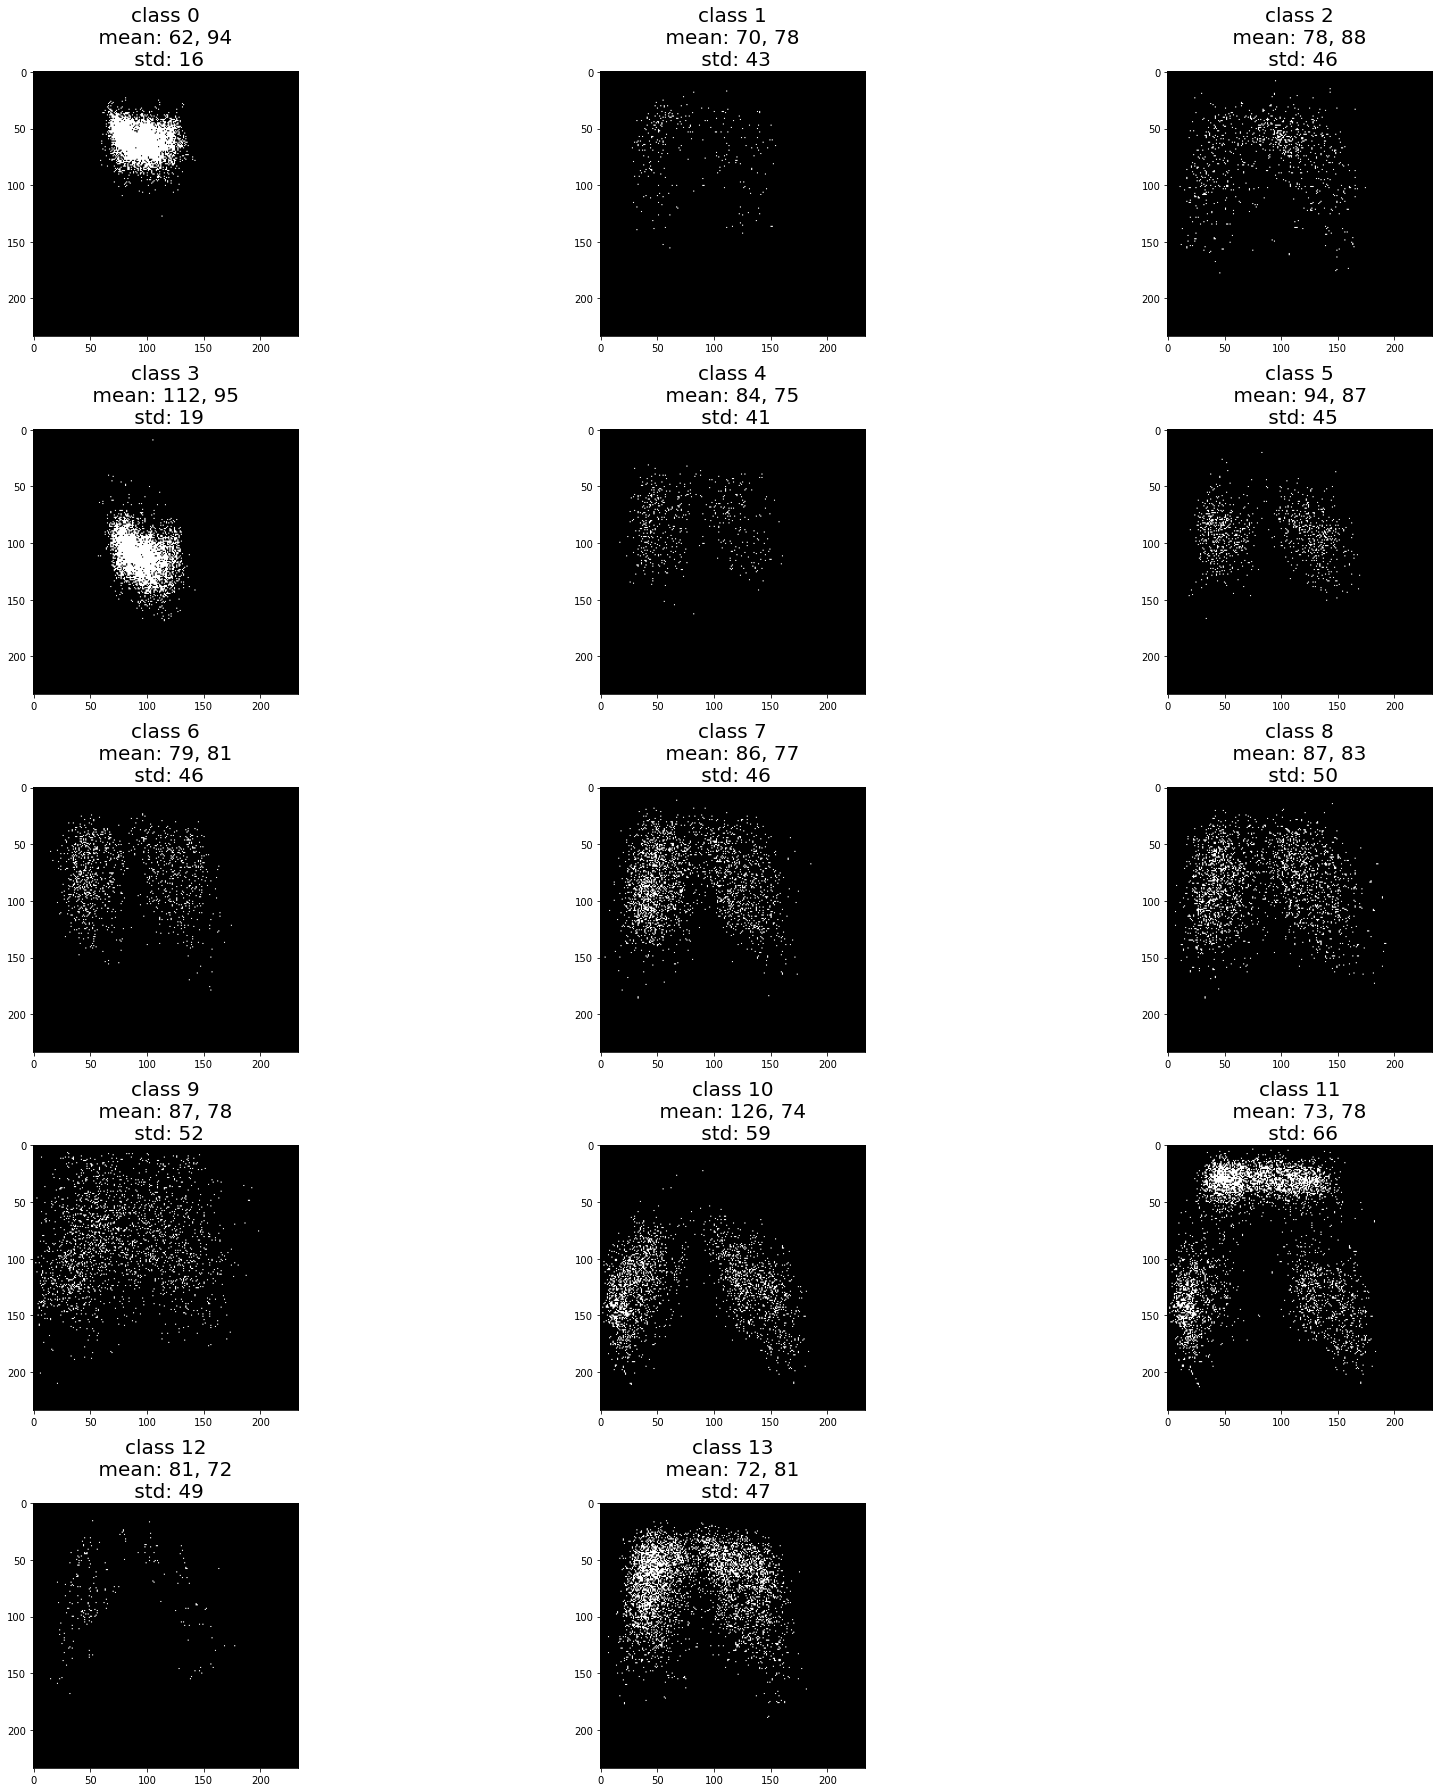

In [15]:
import matplotlib.pyplot as plt
import numpy as np

h, w = (5, 3)
fig, axes = plt.subplots(h,w,figsize=(25,25))
number_of_classes = len(set(train_df.class_id)) - 1
factor = 15
for class_id in range(number_of_classes):
  centArr = getCenterOfRectangle(train_df, class_id)
  mean, std = calculateMeanAndStd(centArr, factor)
  posArr = accumulatePosArr(centArr,imShape)
  posArr = scaleDownPosArr(posArr, factor, True)
  #print(class_id // w, class_id % w)
  i, j = (class_id // w, class_id % w)
  axes[i, j].imshow(posArr, cmap = "gray")
  axes[i, j].set_title("class {}\n mean: {:.0f}, {:.0f} \n std: {:.0f}".format(class_id,\
                                                      mean[0],mean[1],std),fontsize=20)
fig.delaxes(axes[-1,-1])
fig.tight_layout()
fig.savefig("bounding_box_distr.png")

# Part 3

## create array holding the number of times classes appear on the same image

In [16]:
number_of_classes = len(set(train_df.class_id))
table = np.zeros((number_of_classes,number_of_classes))
grouped = train_df.loc[:,["image_id","class_id","rad_id"]].groupby('image_id')
for idx, group in grouped:
  class_group = group.groupby(["class_id"])
  classes_appeared_once = []
  for idx_cl_id, group_cl_id in class_group:
    unique, counts = np.unique(group_cl_id.rad_id, return_counts=True)
    if np.max(counts) == 1:
      classes_appeared_once.append(idx_cl_id)
  class_group_ind = class_group.count().index
  mesh = np.array(np.meshgrid(class_group_ind, class_group_ind))
  combinations = mesh.T.reshape(-1, 2)
  table[combinations[:,0],combinations[:,1]] += 1
  table[classes_appeared_once,classes_appeared_once] -= 1 
  #break

## plot heatmap

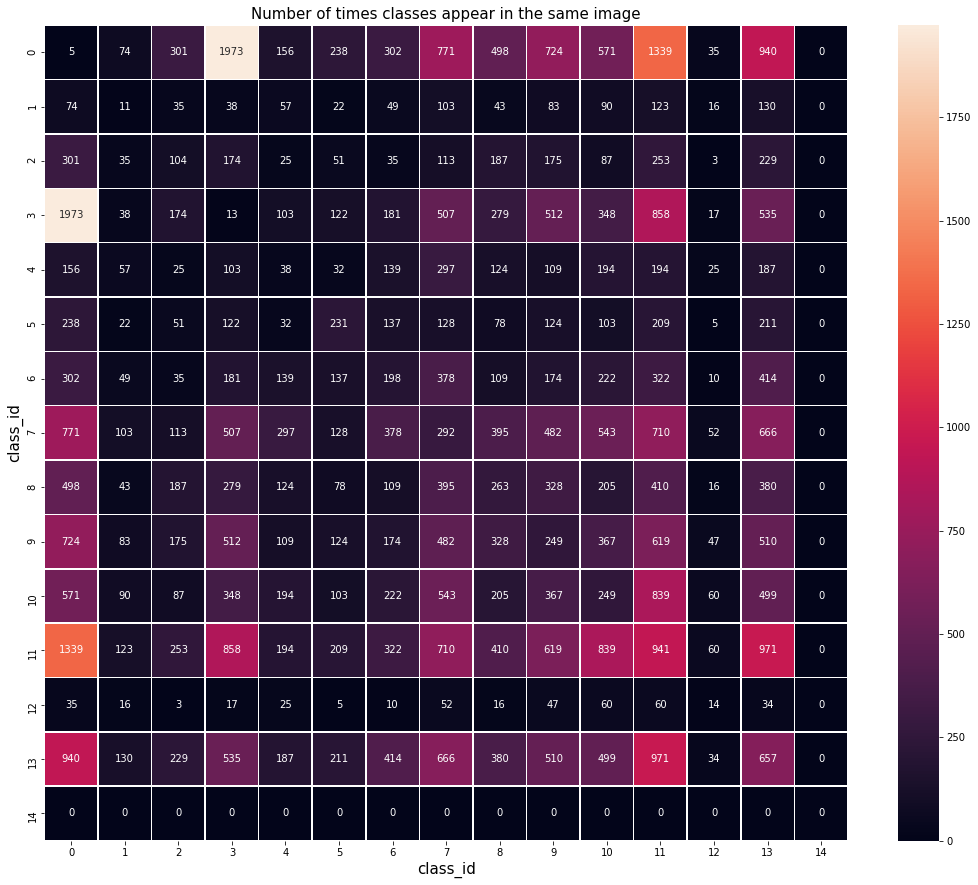

In [17]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(18,15)) 
ax = sns.heatmap(table, annot=True, linewidths=.5, fmt='g')
ax.set_title("Number of times classes appear in the same image", fontsize=15)
ax.set_xlabel('class_id', fontsize = 15)
ax.set_ylabel('class_id', fontsize = 15)
fig.savefig("Number of times classes appear in the same image.png")